# Full Exometabolome Simulations

Here we will simulate bacterial community metabolic dynamics using `cdFBA` and include every secreted and uptaken substrate for all species involved in the simulation. To do this, we will use three representative species from the human gut microbiome as identified by Maya Abdalla

In [1]:
from copy import deepcopy
import time

from process_bigraph import Composite
from process_bigraph import ProcessTypes

from cdFBA import register_types
from cdFBA.processes.dfba import dFBA, UpdateEnvironment, StaticConcentration, Injector, WaveFunction
from process_bigraph.emitter import gather_emitter_results, emitter_from_wires

from cdFBA.utils import make_cdfba_composite, get_injector_spec, get_wave_spec, get_static_spec, get_exchanges, \
    get_initial_counts, set_counts, get_combined_exchanges, set_concentration, model_from_file

from matplotlib import pyplot as plt
from pprint import pprint

import cProfile
import pstats
import io

In [2]:
model_dict = {
        'S.anginosus' : 'representative_species/Streptococcus_anginosus_1_2_62CV.xml',
        'P.uenonis' : 'representative_species/Porphyromonas_uenonis_60_3.xml',
        'S.thoraltensis' : 'representative_species/Streptococcus_thoraltensis_DSM_12221.xml',
        'S.sonnei' : 'representative_species/Shigella_sonnei_Ss046.xml',
        # 'B.fragilis' : 'representative_species/Bacteroides_fragilis_NCTC_9343.mat',
        'S.solfataricus' : 'representative_species/Sulfolobus_solfataricus_P2.xml',
        'C.bartlettii' : 'representative_species/Clostridium_bartlettii_DSM_16795.xml',
    }
exchanges = get_combined_exchanges(model_dict, medium_type='exchange')
volume = 10
spec = make_cdfba_composite(
    model_dict,
    medium_type='exchange',
    # exchanges=exchanges,
    volume=volume,
    interval=0.01
)

In [3]:
base_concentration = 1000
initial_counts = get_initial_counts(
    model_dict,
    biomass=0.25,
    initial_value=(base_concentration*volume),
    exchanges=exchanges
)

In [4]:
set_counts(spec, initial_counts)

In [5]:
for species in model_dict.keys():
    spec['Species'][species]['config']['bounds'] = {
            "EX_o2(e)": {"lower": -1, "upper": None},
            "DM_atp_c_": {"lower": 1, "upper": 1}
        }

In [6]:
#set emitter specs
spec['emitter'] = emitter_from_wires(
    {
        "shared_environment": ["Shared Environment"],
        "dfba_results": ["dFBA Results"],
        "global_time": ["global_time"]
    }
)

In [7]:
#create the core object
core = ProcessTypes()
#register data types
core = register_types(core)
#register all processes and steps
core.register_process('dFBA', dFBA)
core.register_process('UpdateEnvironment', UpdateEnvironment)
core.register_process('StaticConcentration', StaticConcentration)
core.register_process('WaveFunction', WaveFunction)
core.register_process('Injector', Injector)

In [8]:
#create simulation composite
sim = Composite({
        "state": spec,
        },
        core=core
    )

In [9]:
sim.run(20)

/opt/anaconda3/envs/fbapractice/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [10]:
#gather results
results = gather_emitter_results(sim)[('emitter',)]

In [11]:
#extract time-series data
timepoints = []
for timepoint in results:
    time = timepoint.pop('global_time')
    timepoints.append(time)
env = [timepoint['shared_environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

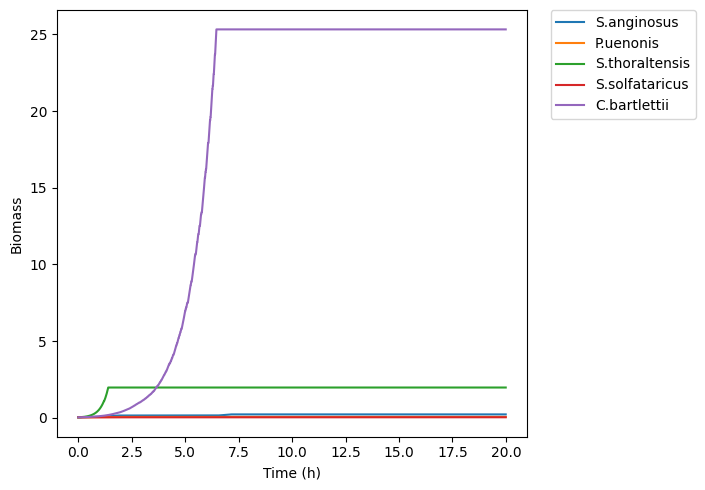

In [12]:
#plot results for biomass
fig, ax = plt.subplots(figsize=(7.2, 5), dpi=100)
for key, value in env_combined.items():
    if (key in model_dict.keys()) & (key != "S.sonnei"):
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time (h)')
plt.ylabel('Biomass')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

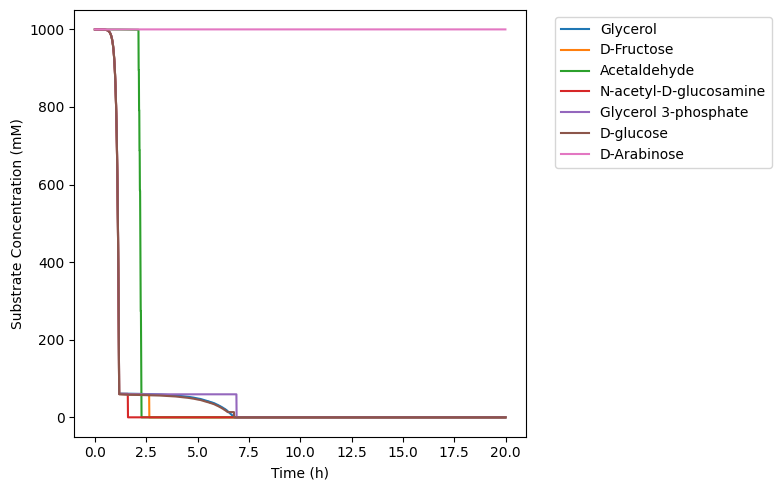

In [13]:
#plote substrates
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
for key, value in env_combined.items():
    if key in ['D-glucose', 'D-Fructose', 'Acetaldehyde', 'D-Arabinose', 'N-acetyl-D-glucosamine', 'Glycerol', 'Glycerol 3-phosphate']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time (h)')
plt.ylabel('Substrate Concentration (mM)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

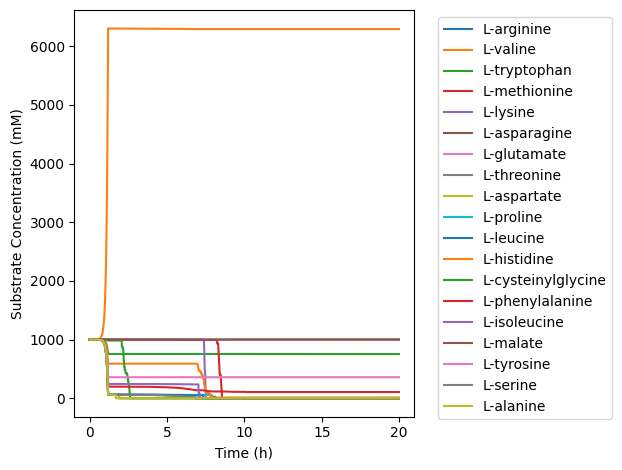

In [14]:
#plote substrates
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key in [
         'L-alanine',
         'L-arginine',
         'L-asparagine',
         'L-aspartate',
         'L-cysteinylglycine',
         'L-glutamate',
         'L-histidine',
         'L-isoleucine',
         'L-leucine',
         'L-lysine',
         'L-malate',
         'L-methionine',
         'L-phenylalanine',
         'L-proline',
         'L-serine',
         'L-threonine',
         'L-tryptophan',
         'L-tyrosine',
         'L-valine',
    ]:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time (h)')
plt.ylabel('Substrate Concentration (mM)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [15]:
def find_reactions_with_exact_metabolites(model, metabolite_ids):
    """
    Returns a list of reactions that involve exactly the metabolites in the provided list,
    with no additional metabolites.

    Parameters:
    - model: cobra.Model
    - metabolite_ids: list of metabolite IDs (strings)

    Returns:
    - List of cobra.Reaction objects
    """
    target_set = set(metabolite_ids)
    matching_reactions = []

    for rxn in model.reactions:
        rxn_met_ids = set([met.id for met in rxn.metabolites])
        if rxn_met_ids == target_set:
            matching_reactions.append(rxn)

    return matching_reactions

In [16]:
sorted(list(spec["Shared Environment"]["counts"].keys()))

['(3,4-dihydroxyphenyl)acetate',
 '(4-hydroxyphenyl)acetaldehyde',
 '(Bis-(P-Hydroxyphenyl)-Pyridyl-2-Methane',
 '(E)-5-(2-Bromovinyl)Uracil',
 '(R)-3-hydroxybutyrate',
 '(R)-Acetoin',
 '(R)-Pantothenate',
 '(S)-propane-1,2-diol',
 '1,5-Diaminopentane',
 '1-OH-midazolam',
 '1-OH-midazolam-glucuronide',
 '1-hydroxy S-ibuprofen',
 '1-hydroxy S-ibuprofen-glucuronide',
 '16-Glucuronide-estriol',
 '17beta-estradiol 3-glucosiduronic acid',
 '2,2-Difluorodeoxyuridine',
 '2,3-dihydroxicinnamic acid',
 '2-Dehydro-3-deoxy-D-gluconate',
 '2-Demethylmenaquinone 8',
 '2-Hydroxy Carbamazepine Glucuronide',
 '2-Hydroxycarbamazepine',
 '2-Hydroxymetronidazole',
 '2-Hydroxymetronidazole Glucuronide',
 '2-Oxoglutarate',
 '2-Sulfamoylacetylphenol',
 '2-Sulfamoylacetylphenol Glucuronide',
 '2-deoxy-D-ribose',
 '2-deoxyadenosine',
 '2-hydroxy S-ibuprofen-glucuronide',
 '2-hydroxy-S-ibuprofen',
 '2-hydroxy-atorvastatin-acid / ortho-hydroxy-atorvastatin acid',
 '2-hydroxy-atorvastatin-acyl-glucuronide',
 '2-

In [17]:
from bigraph_viz import plot_bigraph

In [18]:
plot_bigraph(spec)

In [ ]:
time = []
concentrations = {}
for result in results:
